Affichage des classes

In [ ]:
import os

def list_classes(dataset_path):
    train_path = os.path.join(dataset_path, 'train')
    classes = sorted(os.listdir(train_path))
    print("Classes in the dataset:")
    print(classes)
    return classes

# afficher  Les classes 
dataset_path = "./ModelNet10/"
classes = list_classes(dataset_path)
print(len(classes))


Classes in the dataset:
['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']
10


nuage des points

In [83]:
import open3d as o3d
import numpy as np

def load_point_cloud(file_path):
    mesh = o3d.io.read_triangle_mesh(file_path)
    point_cloud = mesh.sample_points_uniformly(number_of_points=2048)
    return point_cloud

def visualize_point_cloud(point_cloud):
    o3d.visualization.draw_geometries([point_cloud])

# Exemple d'utilisation
sample_file = "./ModelNet10/train/chair/chair_0001.off"
point_cloud = load_point_cloud(sample_file)
visualize_point_cloud(point_cloud)


charge et prépare le dataset ModelNet10

In [67]:

import os
import glob
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ModelNet10Dataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        
        #Chargement des fichiers
        self.classes = sorted(os.listdir(os.path.join(root_dir, split)))
        self.data = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, split, class_name)
            files = glob.glob(os.path.join(class_path, "*.off"))  # Assuming OFF file format
            for file in files:
                pointcloud = self._read_off(file)
                self.data.append(pointcloud)
                self.labels.append(label)

    #Lecture des fichiers OFF
    def _read_off(self, filepath):
        """Reads an OFF file and returns a point cloud."""
        with open(filepath, 'r') as f:
            if 'OFF' not in f.readline():
                raise ValueError("Not a valid OFF file")
            n_verts, n_faces, _ = map(int, f.readline().strip().split())
            vertices = []
            for _ in range(n_verts):
                vertices.append(list(map(float, f.readline().strip().split())))
        return np.array(vertices)

    def __len__(self):
        return len(self.data)

    #Retourne le nombre d'échantillons dans le dataset.
    def __getitem__(self, idx):
        pointcloud = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            pointcloud = self.transform(pointcloud)
        return {'pointcloud': pointcloud, 'category': label}


1. Prétraitement des données



In [80]:
#Transformations pour les Nuages de Points
#Rotation autour de l'axe Z
class RandRotation_Z:
    """Random rotation around the Z-axis."""
    def __call__(self, pointcloud):
        theta = np.random.uniform(0, 2 * np.pi)
        rotation_matrix = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta),  np.cos(theta), 0],
            [0,              0,             1]
        ])
        return np.dot(pointcloud, rotation_matrix.T)
    
#Ajoute du bruit gaussien pour simuler des perturbations réelles.
class AddNoise:
    """Adds Gaussian noise to point clouds."""
    def __call__(self, pointcloud):
        noise = np.random.normal(0, 0.02, pointcloud.shape)
        return pointcloud + noise
    
#Centrage et normalisation du nuage de points dans une unité sphérique.
class Normalize:
    """Normalizes the point cloud."""
    def __call__(self, pointcloud):
        centroid = np.mean(pointcloud, axis=0)
        pointcloud -= centroid
        max_dist = np.max(np.linalg.norm(pointcloud, axis=1))
        pointcloud /= max_dist
        return pointcloud


# Augmentations supplémentaires
#Applique une mise à l'échelle aléatoire dans une plage spécifiée.
class RandomScaling:
    """Applique un scaling aléatoire à la point cloud."""
    def __init__(self, scale_range=(0.8, 1.2)):
        self.scale_range = scale_range

    def __call__(self, pointcloud):
        scale = np.random.uniform(*self.scale_range)
        return pointcloud * scale

#Échantillonnage à Taille Fixe
#Échantillonne un nombre fixe de points (sur-échantillonne ou sous-échantillonne).
class FixedSizeSampler:
    def __init__(self, num_points=1024):
        self.num_points = num_points

    def __call__(self, pointcloud):
        if pointcloud.shape[0] > self.num_points:
            # Sous-échantillonner si trop de points
            indices = np.random.choice(pointcloud.shape[0], self.num_points, replace=False)
        elif pointcloud.shape[0] < self.num_points:
            # Sur-échantillonner si pas assez de points
            indices = np.random.choice(pointcloud.shape[0], self.num_points, replace=True)
        else:
            indices = np.arange(self.num_points)
        return pointcloud[indices]


In [69]:
from torch.utils.data import DataLoader
from torchvision import transforms

# Mise à jour des transformations d'augmentation pour l'entraînement
train_transforms = transforms.Compose([
    FixedSizeSampler(num_points=1024),
    RandRotation_Z(),
    AddNoise(),
    RandomScaling(scale_range=(0.8, 1.2)),  # Ajout de scaling aléatoire
    Normalize(),
])

test_transforms = transforms.Compose([
    FixedSizeSampler(num_points=1024),
    Normalize(),
])



Chargement des Données

In [44]:
train_dataset = ModelNet10Dataset(root_dir="ModelNet10", split='train', transform=train_transforms)
test_dataset = ModelNet10Dataset(root_dir="ModelNet10", split='test', transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


*Architecture de PointNet<br>*
Tnet : Sous-module pour la transformation matricielle (3x3 et 64x64).<br>
Transform : Module de traitement des nuages de points (extraction de caractéristiques).<br>
PointNet : Réseau principal avec couches entièrement connectées pour la classification.<br>

In [70]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix

#applique des transformations en entrée et au niveau des features
class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64
#extrait des caractéristiques du nuage de points, puis les utilise pour effectuer la classification.
class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

Fonction de Perte

Combine la perte d'entropie croisée et une régularisation pour imposer une contrainte d'orthogonalité.

In [71]:
#extrait des caractéristiques du nuage de points, puis les utilise pour effectuer la classification.
def pointnetloss(outputs, labels, m3x3, m64x64, alpha=0.0001):

    # Cross-entropy loss for classification
    criterion = torch.nn.CrossEntropyLoss()
    classification_loss = criterion(outputs, labels)

    # pénalise les matrices de transformation qui s'écartent d'une matrice identité pour garantir l'orthogonalité.
    bs = outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=False).repeat(bs, 1, 1).to(outputs.device)  # Identity matrix for 3x3
    id64x64 = torch.eye(64, requires_grad=False).repeat(bs, 1, 1).to(outputs.device)  # Identity matrix for 64x64

    # Orthogonality constraint: ||I - A * A^T||^2
    diff3x3 = id3x3 - torch.bmm(m3x3, m3x3.transpose(1, 2))
    diff64x64 = id64x64 - torch.bmm(m64x64, m64x64.transpose(1, 2))
    regularization_loss = alpha * (torch.norm(diff3x3, dim=(1, 2)).mean() + torch.norm(diff64x64, dim=(1, 2)).mean())

    return classification_loss + regularization_loss


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [73]:

model = PointNet()
model.to(device)


PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

Le modèle est entraîné avec un optimiseur Adam..

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)

Entraînement



In [53]:
def train(model, train_loader, val_loader=None,  epochs=10):
    for epoch in range(epochs): 
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = model(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 125 == 0:    # print every 10 mini-batches
                print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                    (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                running_loss = 0.0

        model.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = model(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        torch.save(model.state_dict(), "model5.pth")


In [54]:
train(model, train_loader, valid_loader)


[Epoch: 1, Batch:    1 /  125], loss: 0.231
Valid accuracy: 54 %
[Epoch: 2, Batch:    1 /  125], loss: 0.096
Valid accuracy: 60 %
[Epoch: 3, Batch:    1 /  125], loss: 0.104
Valid accuracy: 64 %
[Epoch: 4, Batch:    1 /  125], loss: 0.060
Valid accuracy: 68 %
[Epoch: 5, Batch:    1 /  125], loss: 0.104
Valid accuracy: 65 %
[Epoch: 6, Batch:    1 /  125], loss: 0.093
Valid accuracy: 66 %
[Epoch: 7, Batch:    1 /  125], loss: 0.044
Valid accuracy: 73 %
[Epoch: 8, Batch:    1 /  125], loss: 0.055
Valid accuracy: 74 %
[Epoch: 9, Batch:    1 /  125], loss: 0.072
Valid accuracy: 73 %
[Epoch: 10, Batch:    1 /  125], loss: 0.059
Valid accuracy: 77 %


Visualisation des Prédictions

In [84]:
import open3d as o3d
import numpy as np
#Les points correctement classés apparaissent en vert, et les erreurs en rouge.

def visualize_predictions(point_cloud, labels, predictions):
    # Convertir le nuage de points en tableau numpy si ce n'est pas déjà fait
    if isinstance(point_cloud, o3d.geometry.PointCloud):
        points = np.asarray(point_cloud.points)
    else:
        points = point_cloud

    # Créer une carte de couleurs pour les étiquettes et les prédictions
    colors = np.zeros((points.shape[0], 3))
    for i in range(points.shape[0]):
        if labels[i] == predictions[i]:
            colors[i] = [0, 1, 0]  # Vert pour les prédictions correctes
        else:
            colors[i] = [1, 0, 0]  # Rouge pour les prédictions incorrectes

    # Créer un nouveau nuage de points avec les points colorés
    colored_pcd = o3d.geometry.PointCloud()
    colored_pcd.points = o3d.utility.Vector3dVector(points)
    colored_pcd.colors = o3d.utility.Vector3dVector(colors)

    # Visualiser le nuage de points
    o3d.visualization.draw_geometries([colored_pcd])

# Exemple d'utilisation
point_cloud = o3d.io.read_triangle_mesh('ModelNet10/train/sofa/sofa_0001.off').sample_points_uniformly(1024)

# Vérifiez si le nuage de points est chargé correctement
if point_cloud.is_empty():
    print("Failed to load the point cloud. Please check the file path.")
else:
    print("Point cloud loaded successfully.")

# Créez des étiquettes et des prédictions fictives pour tester la visualisation
num_points = len(point_cloud.points)
labels = np.random.randint(0, 2, num_points)  # Remplacez par vos étiquettes réelles
predictions = np.random.randint(0, 2, num_points)  # Remplacez par vos prédictions réelles

visualize_predictions(point_cloud, labels, predictions)

Point cloud loaded successfully.
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: L’opération de transformation demandée n’est pas prise en charge. 


C:\Users\moham\AppData\Local\Temp\ipykernel_16084\2144989007.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model5.pth"))  # Assurez-

Accuracy: 77.64%


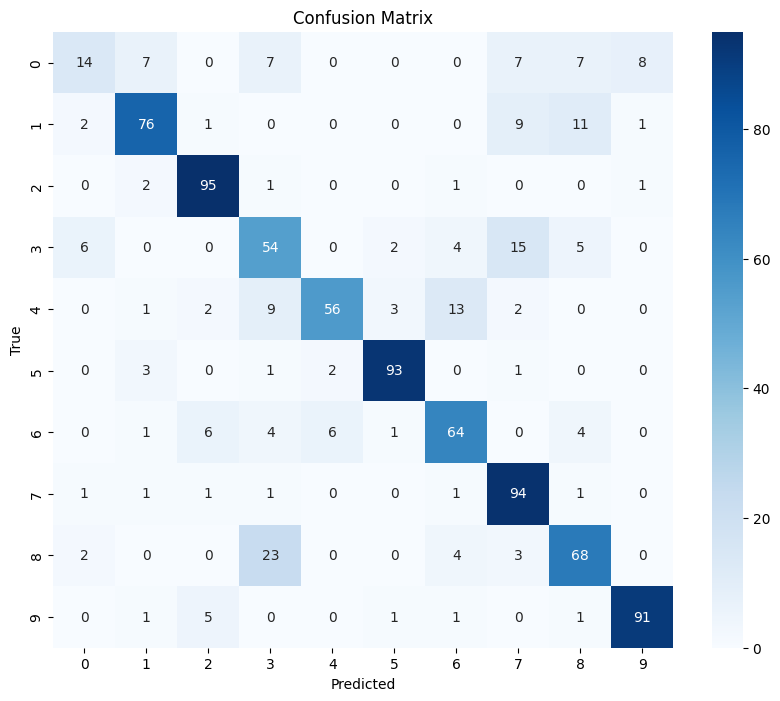


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.56      0.28      0.37        50
     Class 1       0.83      0.76      0.79       100
     Class 2       0.86      0.95      0.90       100
     Class 3       0.54      0.63      0.58        86
     Class 4       0.88      0.65      0.75        86
     Class 5       0.93      0.93      0.93       100
     Class 6       0.73      0.74      0.74        86
     Class 7       0.72      0.94      0.81       100
     Class 8       0.70      0.68      0.69       100
     Class 9       0.90      0.91      0.91       100

    accuracy                           0.78       908
   macro avg       0.76      0.75      0.75       908
weighted avg       0.78      0.78      0.77       908



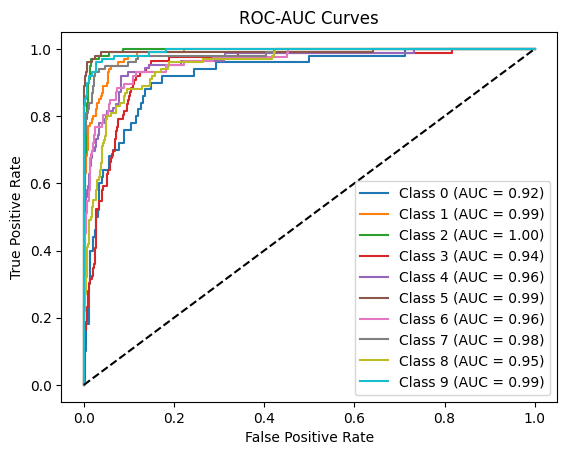

In [76]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score,classification_report,roc_curve
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import seaborn as sns



def evaluate_model(model, loader, num_classes=10):
    model.load_state_dict(torch.load("model5.pth"))  # Assurez-vous que le nom du fichier modèle est correct

    model.eval()
    all_preds = []
    all_labels = []
    #Collecte des prédictions et des labels
    with torch.no_grad():
        for data in loader:
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            outputs, __, __ = model(inputs.transpose(1, 2))
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy globale
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    print(f"Accuracy: {accuracy:.2f}%")

    # Matrice de confusion
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Rapport de classification
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(num_classes)]))

    # Courbes ROC-AUC pour chaque classe
    all_probs = []
    for data in loader:
        inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
        outputs, __, __ = model(inputs.transpose(1, 2))
        all_probs.extend(torch.softmax(outputs, dim=1).detach().cpu().numpy())  # Correction ici

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    roc_auc = {}

    for i in range(num_classes):
        y_true = (all_labels == i).astype(int)
        y_score = all_probs[:, i]
        roc_auc[i] = roc_auc_score(y_true, y_score)

        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curves")
    plt.legend()
    plt.show()

    return accuracy, roc_auc


# Entraîner le modèle et évaluer les performances
#train(pointnet, train_loader, valid_loader)

# Évaluation
accuracy, roc_auc = evaluate_model(model, valid_loader, num_classes=10)


C:\Users\moham\AppData\Local\Temp\ipykernel_16084\2297696744.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model5.pth"))  # Assurez-v

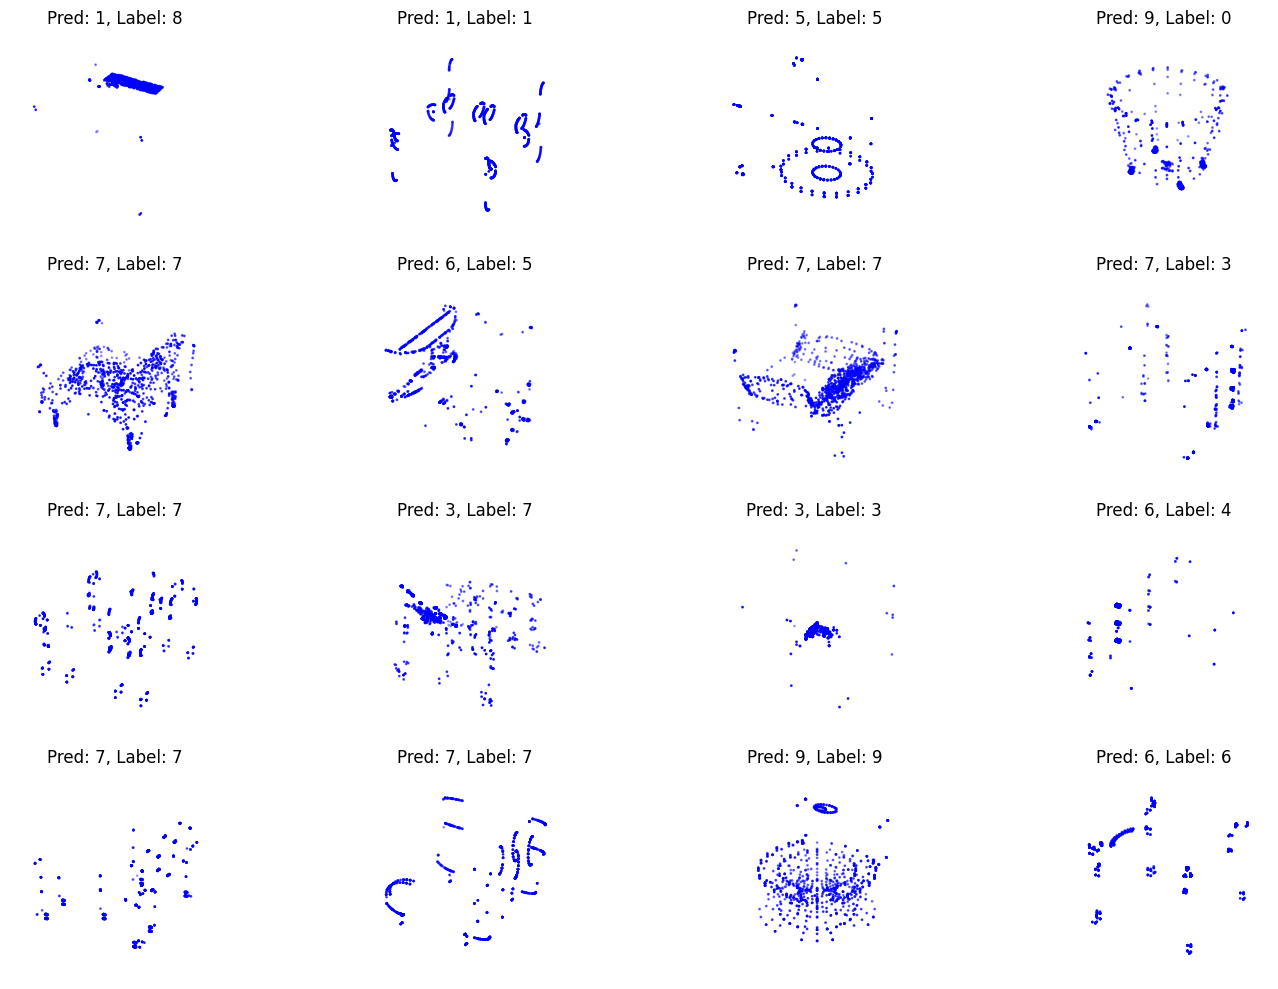

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Nécessaire pour les tracés 3D

# Charger le modèle entraîné
model = PointNet(classes=10)
model.load_state_dict(torch.load("model5.pth"))  # Assurez-vous que le nom du fichier modèle est correct
model.to(device)
model.eval()  # Met le modèle en mode évaluation

# Sélectionner un échantillon du dataset de test
num_samples = 16  # Nombre d'exemples à visualiser
indices = np.random.choice(len(test_dataset), num_samples, replace=False)  # Choisir des indices aléatoires

points_list = []
labels_list = []
predictions_list = []

with torch.no_grad():
    for idx in indices:
        # Charger un nuage de points et son étiquette
        sample = test_dataset[idx]
        pointcloud = sample['pointcloud']  # Nuage de points
        label = sample['category']  # Étiquette

        # Convertir les données pour le modèle
        input_tensor = torch.tensor(pointcloud, dtype=torch.float32).unsqueeze(0).transpose(1, 2).to(device)

        # Effectuer la prédiction
        output, _, _ = model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()

        # Stocker les données
        points_list.append(pointcloud)
        labels_list.append(label)
        predictions_list.append(prediction)

# Visualisation des prédictions
fig = plt.figure(figsize=(15, 10))

for i in range(num_samples):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    pointcloud = points_list[i]
    label = labels_list[i]
    prediction = predictions_list[i]

    # Tracer le nuage de points
    ax.scatter(pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2], c='b', s=1)

    # Ajouter le titre avec la prédiction et l'étiquette réelle
    ax.set_title(f"Pred: {prediction}, Label: {label}")
    ax.set_axis_off()  # Cacher les axes pour une visualisation plus claire

plt.tight_layout()
plt.show()
